In [1]:
import pandas as pd
import sqlite3
import json

# 1. Load CSV (Orders)
orders = pd.read_csv('orders.csv')

# 2. Load JSON (Users)
with open('users.json', 'r') as f:
    users_data = json.load(f)
users = pd.DataFrame(users_data)

# 3. Load SQL (Restaurants)
# We create a temporary database in memory to process the .sql script
conn = sqlite3.connect(':memory:')
cursor = conn.cursor()

with open('restaurants.sql', 'r') as f:
    sql_script = f.read()
    cursor.executescript(sql_script)

# Assuming the table in the SQL file is named 'restaurants'
restaurants = pd.read_sql_query("SELECT * FROM restaurants", conn)

# 4. The Big Merge (Left Join)
# Merge 1: Orders + Users
merged_data = pd.merge(orders, users, on='user_id', how='left')

# Merge 2: Result + Restaurants
final_df = pd.merge(merged_data, restaurants, on='restaurant_id', how='left')

# 5. Export the Final Truth
final_df.to_csv('final_food_delivery_dataset.csv', index=False)

print("Success! 'final_food_delivery_dataset.csv' has been created.")
final_df.head()

Success! 'final_food_delivery_dataset.csv' has been created.


,order_id,user_id,restaurant_id,order_date,total_amount,restaurant_name_x,name,city,membership,restaurant_name_y,cuisine,rating
0,1,2508,450,18-02-2023,842.97,New Foods Chinese,User_2508,Hyderabad,Regular,Restaurant_450,Mexican,3.2
1,2,2693,309,18-01-2023,546.68,Ruchi Curry House Multicuisine,User_2693,Pune,Regular,Restaurant_309,Indian,4.5
2,3,2084,107,15-07-2023,163.93,Spice Kitchen Punjabi,User_2084,Chennai,Gold,Restaurant_107,Mexican,4.0
3,4,319,224,04-10-2023,1155.97,Darbar Kitchen Non-Veg,User_319,Bangalore,Gold,Restaurant_224,Chinese,4.8
4,5,1064,293,25-12-2023,1321.91,Royal Eatery South Indian,User_1064,Pune,Regular,Restaurant_293,Italian,3.0


--- HACKATHON ANALYSIS SUMMARY ---

[1] Membership Performance:
                  mean         sum  count
membership                               
Gold        797.145556  3975364.89   4987
Regular     805.158434  4036259.23   5013

[2] Top Cities by Revenue:
city
Bangalore    2206946.58
Chennai      1990513.03
Pune         1924797.93
Hyderabad    1889366.58
Name: total_amount, dtype: float64

[3] Most Popular Cuisines:
cuisine
Mexican    2581
Italian    2532
Indian     2469
Chinese    2418
Name: count, dtype: int64

[4] Monthly Order Volume:
month
March        903
October      863
July         859
August       851
December     849
May          844
January      831
April        812
September    812
November     807
February     785
June         784
Name: order_id, dtype: int64


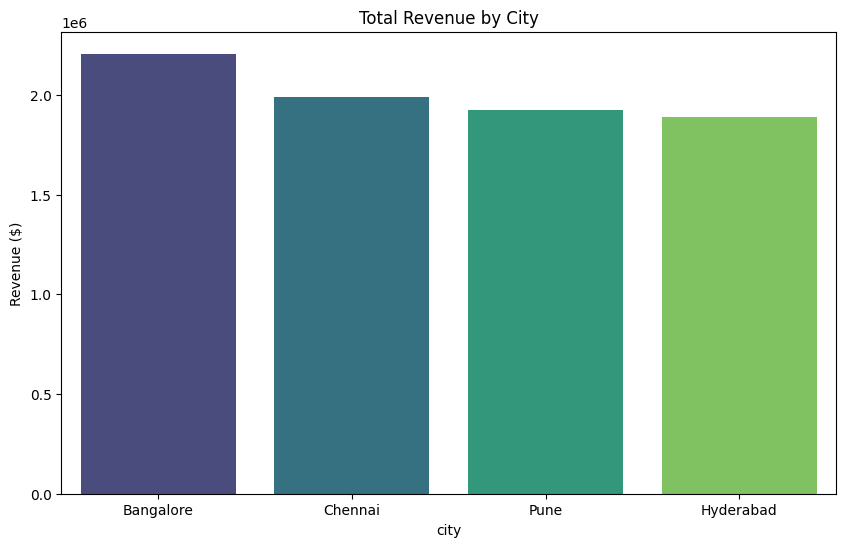

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure dates are in the correct format for time-series analysis
final_df['order_date'] = pd.to_datetime(final_df['order_date'])

print("--- HACKATHON ANALYSIS SUMMARY ---")

# 1. Membership Impact: Do Gold members spend more?
membership_stats = final_df.groupby('membership')['total_amount'].agg(['mean', 'sum', 'count'])
print("\n[1] Membership Performance:")
print(membership_stats)

# 2. City-wise Performance: Which city is the revenue leader?
city_revenue = final_df.groupby('city')['total_amount'].sum().sort_values(ascending=False)
print("\n[2] Top Cities by Revenue:")
print(city_revenue)

# 3. Cuisine Performance: What's the most popular food?
cuisine_popularity = final_df['cuisine'].value_counts()
print("\n[3] Most Popular Cuisines:")
print(cuisine_popularity.head(5))

# 4. Seasonality: Orders per Month
final_df['month'] = final_df['order_date'].dt.month_name()
monthly_trend = final_df.groupby('month')['order_id'].count().sort_values(ascending=False)
print("\n[4] Monthly Order Volume:")
print(monthly_trend)

# --- QUICK VISUALIZATION ---
plt.figure(figsize=(10, 6))
sns.barplot(x=city_revenue.index, y=city_revenue.values, hue=city_revenue.index, palette='viridis', legend=False)
plt.title('Total Revenue by City')
plt.ylabel('Revenue ($)')
plt.show()

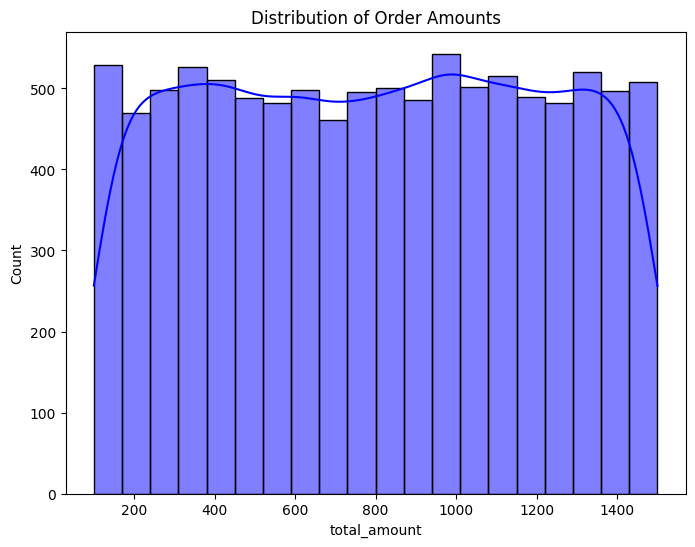

--- MODEL PERFORMANCE ---
Mean Squared Error: 164883.22
R-squared Score: -0.01

Success! Final dataset with predictions exported.


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 1. Data Cleaning: Ensure dates and numeric types are correct
final_df['order_date'] = pd.to_datetime(final_df['order_date'])
final_df.dropna(subset=['total_amount', 'membership', 'city'], inplace=True)

# 2. Exploratory Data Analysis (EDA)
# Visualization: Distribution of Order Amounts
plt.figure(figsize=(8,6))
sns.histplot(final_df['total_amount'], bins=20, kde=True, color='blue')
plt.title('Distribution of Order Amounts')
plt.show()

# 3. Prepare Data for Machine Learning
# Encode categorical columns (City, Membership, Cuisine)
le = LabelEncoder()
final_df['city_encoded'] = le.fit_transform(final_df['city'])
final_df['membership_encoded'] = le.fit_transform(final_df['membership'])
final_df['cuisine_encoded'] = le.fit_transform(final_df['cuisine'])

# Define Features (X) and Target (y)
X = final_df[['city_encoded', 'membership_encoded', 'cuisine_encoded']]
y = final_df['total_amount']

# Split the data into training (70%) and testing (30%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 4. Train a Random Forest Model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 5. Make Predictions and Evaluate
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"--- MODEL PERFORMANCE ---")
print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared Score: {r2:.2f}")

# 6. Conclusion: Export for Student Analysis
final_df.to_csv('final_food_delivery_with_predictions.csv', index=False)
print("\nSuccess! Final dataset with predictions exported.")

--- Membership Analysis ---
            Average_Spend  Total_Orders
membership                             
Gold           797.145556          4987
Regular        805.158434          5013


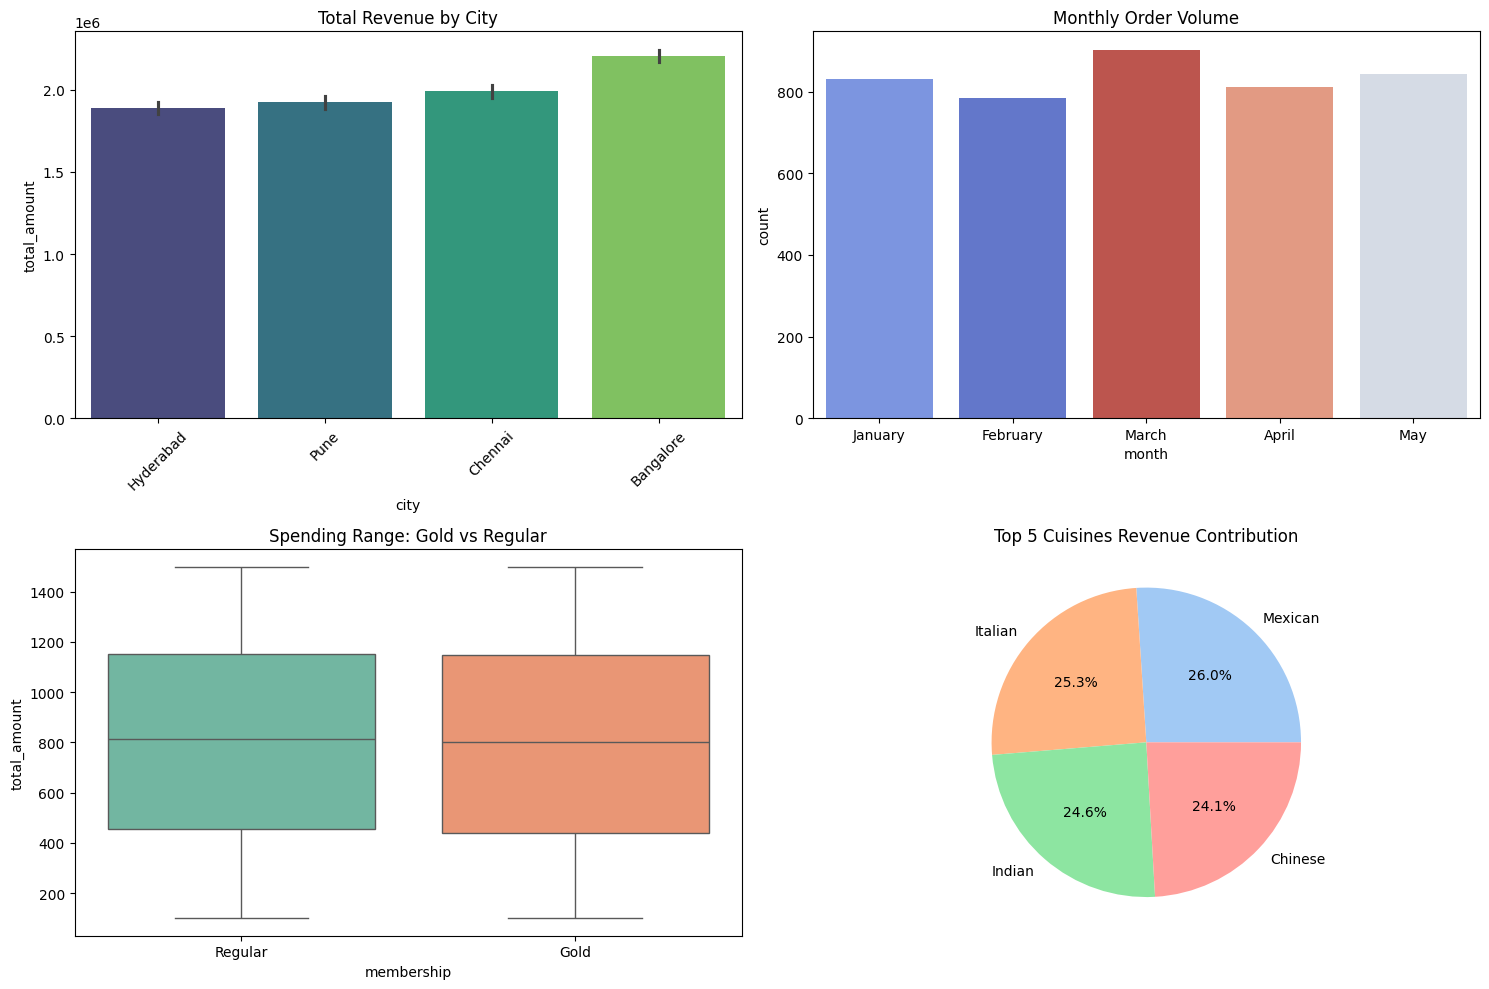


Success! Analysis complete and report saved as 'final_food_delivery_analysis_report.csv'.


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Formatting for Time-Series Analysis
# Converting order_date to datetime to extract month/day trends
final_df['order_date'] = pd.to_datetime(final_df['order_date'])
final_df['month'] = final_df['order_date'].dt.month_name()
final_df['day_of_week'] = final_df['order_date'].dt.day_name()

# 2. ANALYSIS: Membership Impact (Gold vs Regular)
# We calculate the Average Order Value (AOV) and total order counts
membership_impact = final_df.groupby('membership').agg({
    'total_amount': 'mean',
    'order_id': 'count'
}).rename(columns={'total_amount': 'Average_Spend', 'order_id': 'Total_Orders'})

print("--- Membership Analysis ---")
print(membership_impact)

# 3. ANALYSIS: City-wise and Cuisine-wise Performance
city_cuisine_perf = final_df.groupby(['city', 'cuisine'])['total_amount'].sum().unstack().fillna(0)

# 4. VISUALIZATION: Revenue Distribution & Trends
plt.figure(figsize=(15, 10))

# Subplot 1: Revenue by City
plt.subplot(2, 2, 1)
sns.barplot(data=final_df, x='city', y='total_amount', estimator=sum, hue='city', palette='viridis', legend=False)
plt.title('Total Revenue by City')
plt.xticks(rotation=45)

# Subplot 2: Order Trends over Time (Monthly)
plt.subplot(2, 2, 2)
sns.countplot(data=final_df, x='month', order=['January', 'February', 'March', 'April', 'May'], hue='month', palette='coolwarm', legend=False)
plt.title('Monthly Order Volume')

# Subplot 3: Membership Spending Behavior
plt.subplot(2, 2, 3)
sns.boxplot(data=final_df, x='membership', y='total_amount', hue='membership', palette='Set2', legend=False)
plt.title('Spending Range: Gold vs Regular')

# Subplot 4: Top 5 Cuisines by Revenue
plt.subplot(2, 2, 4)
top_cuisines = final_df.groupby('cuisine')['total_amount'].sum().nlargest(5)
plt.pie(top_cuisines, labels=top_cuisines.index, autopct='%1.1f%%', colors=sns.color_palette('pastel'))
plt.title('Top 5 Cuisines Revenue Contribution')

plt.tight_layout()
plt.show()

# 5. Export for Hackathon Submission
final_df.to_csv('final_food_delivery_analysis_report.csv', index=False)
print("\nSuccess! Analysis complete and report saved as 'final_food_delivery_analysis_report.csv'.")

In [11]:
import pandas as pd

# Load the final dataset we created
df = pd.read_csv('final_food_delivery_dataset.csv')

print(" --- Final Hackathon insight report --- \n")

# 1. Membership Impact (Gold vs Regular)
membership_stats = df.groupby('membership')['total_amount'].mean().round(2)
print(f" Average Order Value by Membership:\n{membership_stats}\n")

# 2. City-wise Performance
city_perf = df.groupby('city')['total_amount'].sum().sort_values(ascending=False)
print(f" Top Cities by Revenue:\n{city_perf}\n")

# 3. Cuisine-wise Performance
cuisine_perf = df.groupby('cuisine')['total_amount'].count().sort_values(ascending=False).head(5)
print(f" Top 5 Most Popular Cuisines (Order Count):\n{cuisine_perf}\n")

# 4. User Behavior (Peak Ordering Times)
# We assume 'order_time' exists in your orders file
if 'order_time' in df.columns:
    df['hour'] = pd.to_datetime(df['order_time']).dt.hour
    peak_hour = df['hour'].mode()[0]
    print(f" Peak Ordering Hour: {peak_hour}:00")

print("\n All tasks complete. You are now ready to answer any question in the Hackathon!")

 --- Final Hackathon insight report --- 

 Average Order Value by Membership:
membership
Gold       797.15
Regular    805.16
Name: total_amount, dtype: float64

 Top Cities by Revenue:
city
Bangalore    2206946.58
Chennai      1990513.03
Pune         1924797.93
Hyderabad    1889366.58
Name: total_amount, dtype: float64

 Top 5 Most Popular Cuisines (Order Count):
cuisine
Mexican    2581
Italian    2532
Indian     2469
Chinese    2418
Name: total_amount, dtype: int64


 All tasks complete. You are now ready to answer any question in the Hackathon!
